In [1]:
import sys
import os
import os.path as op

import glob
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import datetime
from matplotlib import pyplot as plt

# wavespectra
from wavespectra.specarray import SpecArray
from wavespectra.specdataset import SpecDataset

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import spectra, plot_spectra, wrapSpectra, io
from lib.config import *

# CFOSAT-Data. A comparison between raw, smoothed and reconstructed spectra

## Preprocess satellite data

In [2]:
# load data tracks and ww3 model output
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))

**Config SWIM parameters**

In [3]:
# side of the nadir track to analyse (0 : right sides ; 1 :left side)
nadir_side = 0

# beam choice for spectra : 6=> beam 6°; 8=> beam 8°; 10=> beam 10° ; 0 => combined (combination of the 3 beams)
#beam = 10
#n_beam_l2 = int((beam-6)/2)

# partitions visualization : True => partitions plotted; False => partitions not plotted
partitions = True

# color bar min and max values ('None' recommended)
vmin, vmax = None, None

**Selection L2 product observation**

In [4]:
# SWIM L2 NetCDF file full name (first file, first box)
dsi = ds_data.isel(file=10).dropna(dim='nbox')
SWIM_L2_NC_file_name = str(dsi.file.values)
num_box = dsi.nbox.values[3]

print('SWIM File: {0}\nNº Box: {1}'.format(SWIM_L2_NC_file_name, num_box))
# 50, 33: same tp opposite direcctions

SWIM File: CFO_OP05_SWI_L2_____F_20210120T160759_20210120T171855.nc
Nº Box: 82


In [5]:
# NetCDF file opening and reading
cdf = xr.open_dataset(glob.glob(op.join(sat_cfosat,  '*', SWIM_L2_NC_file_name))[0], decode_times=False)
cdf = cdf[variables]

In [6]:
# wave wavelength visualization range:
# min wavelength (m), instrument specification :70m
min_wavelength = cdf.wlmin

# max wavelength (m), instrument specification :500m
max_wavelength = cdf.wlmax

# directional delta
#dphi = cdf.dphi

# beams 0,2,4,6,8,10: cdf['n_beam_sig0']
cdf_i = cdf.isel(n_beam_sig0=5, n_posneg=nadir_side, n_box=num_box, n_tim=0)

# wave parameters
swh, pwl, pdir = cdf_i.isel(n_beam_l2=n_beam_l2)['wave_param_part_combined'].values

# Get nadir box time and coordinates
date = (t0 + datetime.timedelta(seconds=float(cdf_i['time_spec_l2']))).strftime('%Y-%m-%dT%H:%M:%S')
lon_coor, lat_coor = cdf_i['lon_spec_l2'], cdf_i['lat_spec_l2']

In [7]:
min_wavelength, max_wavelength

(30.0, 800.0)

### Duplicate Spectra

In [8]:
beam_title = 'beam '+ str(beam)+'$\degree$'

In [9]:
ds_Slope, ds_mask = wrapSpectra.duplicate_spectra(cdf_i, n_beam_l2)

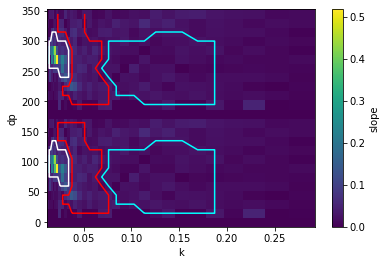

In [10]:
fig, axs = plt.subplots()
ds_Slope.slope.plot(ax=axs)
axs.contour(ds_mask.k, ds_mask.dp, ds_mask.isel(partition=0).slope, levels=[0.999], colors='w')
axs.contour(ds_mask.k, ds_mask.dp, ds_mask.isel(partition=1).slope, levels=[0.999], colors='r')
axs.contour(ds_mask.k, ds_mask.dp, ds_mask.isel(partition=2).slope, levels=[0.999], colors='cyan')

### Mask the partitions with no correlation in MFWAM model

In [10]:
# select mfwam partitions information (file, time, nadir_side, box, lon, lat)
mfwam_sel = wrapSpectra.mfwam_info(SWIM_L2_NC_file_name, date, nadir_side, lon_coor, lat_coor)
cell_model = pd.DataFrame(
    {
        'partition':[1, 2, 3],
        'Hs': [mfwam_sel.shww.values[0], mfwam_sel.swh1.values[0], mfwam_sel.swh2.values[0]],
        'Dir': [mfwam_sel.mdww.values[0], mfwam_sel.mwd1.values[0], mfwam_sel.mwd2.values[0]],
        'Tp': [mfwam_sel.mpww.values[0], mfwam_sel.mwp1.values[0], mfwam_sel.mwp2.values[0]],
    }
)
cell_model['Wl'] = (g*cell_model['Tp']**2)/(2*np.pi)
cell_model

partition    Hs     Dir     Tp          Wl
0          1  0.49   74.27   2.98   13.859404
1          2  2.34  281.62  12.44  241.519823
2          3  0.97  344.97   4.95   38.240399

In [ ]:
dspart_mfwam = cell_model.set_index('partition').to

In [12]:
# Remove the directional ambiguity
mask_dir = wrapSpectra.dir_ambiguity(pdir, pwl, mfwam_sel, lon_coor, lat_coor, swh)
mask_dir

array([286.594,     nan,     nan], dtype=float32)

In [13]:
# firewall
if np.isnan(mask_dir).all():
    print('Non partition matched')
    sys.exit()

### Downscale frequency, direction spectra

In [14]:
dirs = ds_Slope.dp.values
ds_Slope_sp = spectra.remove_amb(cdf_i, ds_Slope, ds_mask, mask_dir)
ds_Slope_s = ds_Slope_sp.sum(dim='partition')

# Resample spectra from 15º to 5º
ds0 = xr.Dataset({'slope':(('dp', 'k'), ds_Slope_s.sel(dp=0).slope.values.reshape(1,-1))},
            coords={'dp': [360], 'k': ds_Slope_s.k.values})

ds1 = xr.combine_by_coords([ds_Slope_s, ds0])

# Resample in directions and frequencies
ds_Slope1 = ds1.interp(dp=np.arange(0, 360, delta_dir), method="linear")
L = np.linspace(20, 500, 50)
ds_Slope1 = ds_Slope1.interp(k=(2*np.pi/L)[::-1], method="linear")


distance, bearing_p1, bearing_p2 = spectra.geoBearing(lon_coor, lat_coor)

### Smooth Spectra by rolling in frequency and direction

In [15]:
ds_Slope1 = ds_Slope1.sel(dp=[345, 350, 355] + list(ds_Slope1.dp.values) + [0, 5, 10])

In [16]:
da_Slope1_roll = ds_Slope1.slope.rolling(k=6, dp=6, center=True).mean() # 


In [17]:
ds_Slope1_roll = da_Slope1_roll.isel(dp=slice(3, 75))
ds_Slope1_roll = ds_Slope1_roll.sel(k=slice(None, 0.127222))
ds_Slope1_roll = ds_Slope1_roll.to_dataset(name='slope')

### Reconstruct Spectra from partitions {Hs, Tp, Dp and Dspr} WAVESPECTRA

In [18]:
# from 2D slope spectrum to density spectrum (freq, dir)
ds_efth = ds_Slope1_roll.copy()
#ds_efth = ds_efth.dropna(dim='k')
ds_efth = spectra.slope2density(ds_efth)

In [19]:
# wind speed and direction
u, v = cdf_i['u10_ecmwf'].values, cdf_i['v10_ecmwf'].values
wdir = np.arctan2(u, v) * 180 / np.pi
wspd = np.sqrt(u**2 + v**2)

ds_efth = ds_efth.assign(wspd = wspd, wdir = wdir, dpt = 100000)

In [20]:
# wavespectra partitions
num_swells = np.count_nonzero(~np.isnan(mask_dir))
dspart = ds_efth.spec.partition(ds_efth.wspd, ds_efth.wdir, ds_efth.dpt, swells=3, agefac=1.7, wscut=0.0001)
dspart_stats = dspart.spec.stats(["hs", "dpm", "tp", "dspr"]).load()

In [21]:
gamma = 3

In [22]:
# reconstruc Jonswap-type spectrum
%time
ds_jonswap = spectra.jonswap_spectrum(dspart.freq, dspart.dir, gamma, dspart_stats)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


### Nearest spectra from WW3 model

In [24]:
date64 = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
dayYear = date64.strftime('%j')

# WW3 model path
files = os.listdir(op.join(ww3_spectra_proccessed, dayYear))
df_data = io.load_files(files)

# loc time and coordinates of Dataset
nameFile = df_data.sort_values('dates_st').loc[df_data.dates_st < date].iloc[[-1]].name.values[0]

model_spec = xr.open_dataset(op.join(ww3_spectra_proccessed, dayYear, nameFile))
model_spec = model_spec.isel(cell=nadir_side, row=num_box)

# Flip direction
model_spec_efth = model_spec.rename({'direction':'dir', 'frequency':'freq', 'ww3_efth':'efth'})
model_spec_efth = model_spec_efth.transpose('freq', 'dir')

xc = []
for pd, dirt in enumerate(model_spec.direction.values):
    if dirt < 180: xc.append(dirt + 180)
    else: xc.append(dirt - 180)
model_spec_efth['dir'] = xc

# From efth (radians) to frequency
model_spec_efth['efth'] = model_spec_efth['efth'] * (np.pi/360)

___

## Plot 2D mean slope spectrum from CFOSAT and WW3 spectral density

<span style='background:khaki'> **2D Mean Slope Spectra**<br>
     </span>

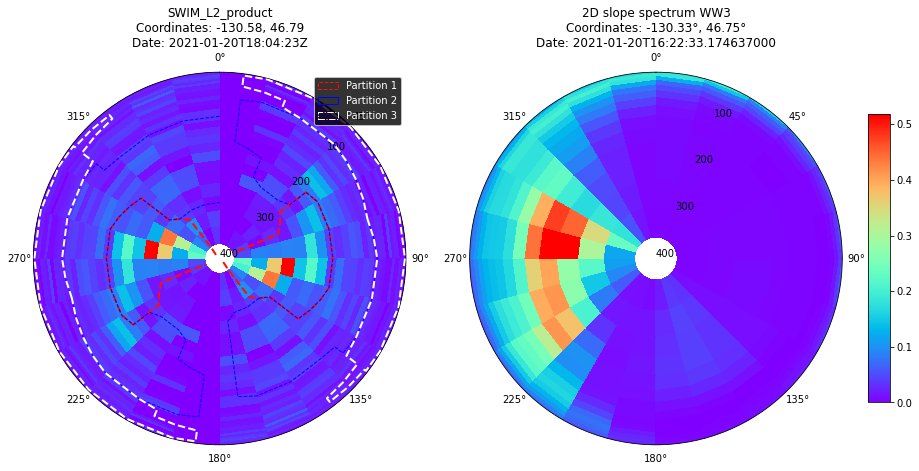

In [25]:
vmin, vmax = 0, ds_Slope.slope.max()
lmin, lmax = 30, 400

partitions = True
cmap = 'rainbow'

# partitions-spectra map
fig = plt.figure(figsize=(12,10), constrained_layout=True)
gs = fig.add_gridspec(1, 2, wspace=0.2)
axa = fig.add_subplot(gs[0, 0], projection='polar')
axb = fig.add_subplot(gs[0, 1], projection='polar')

fig, axt = plot_spectra.plotSpectra(fig, axa, cdf_i, ds_Slope, ds_mask, vmin, vmax, lmin, lmax, True)
fig, axc = plot_spectra.plotModel(fig, axb, model_spec, cmap, vmin, vmax, lmin, lmax)

In [26]:
cell_model

partition    Hs     Dir     Tp          Wl
0          1  0.49   74.27   2.98   13.859404
1          2  2.34  281.62  12.44  241.519823
2          3  0.97  344.97   4.95   38.240399

___

## Plot Downscaled and Smoothed Spectra 

<span style='background:khaki'> **2D wave directional variance spectral density**<br>
     </span>

In [28]:
ds_Slope1_efth = spectra.slope2density(ds_Slope1)
ds_Slope1_efth = ds_Slope1_efth.transpose('freq', 'dir')

ds_Slope1_roll_efth = spectra.slope2density(ds_Slope1_roll)
ds_Slope1_roll_efth = ds_Slope1_roll_efth.transpose('freq', 'dir')

In [29]:
ds_Slope_efth = spectra.slope2density(ds_Slope)
ds_Slope_efth = ds_Slope_efth.transpose('freq', 'dir')

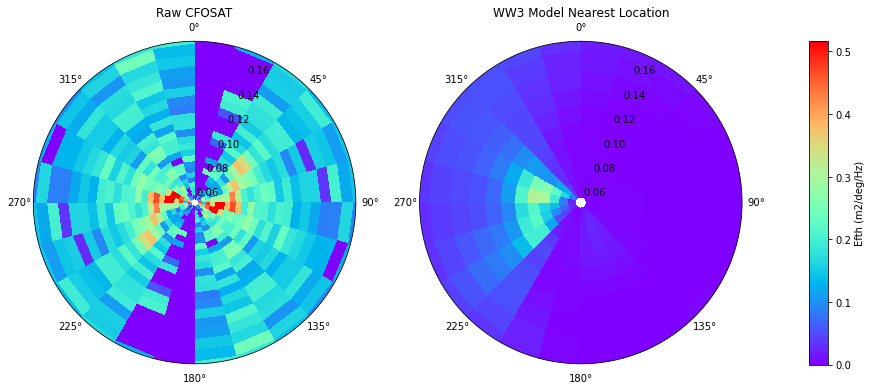

In [30]:
rmin, rmax = ds_Slope1_roll_efth.freq.min(), ds_Slope1_roll_efth.freq.max()
vmax = np.nanmax([ds_Slope_efth.efth.max(), model_spec_efth.efth.max()])

cmap = 'rainbow'

# partitions-spectra map
fig = plt.figure(figsize=(12,10), constrained_layout=True)
gs = fig.add_gridspec(1, 2, wspace=0.2)
axa = fig.add_subplot(gs[0, 0], projection='polar')
axb = fig.add_subplot(gs[0, 1], projection='polar')

ima = plot_spectra.plot_spectrum(axa, ds_Slope_efth.dir, ds_Slope_efth.freq, ds_Slope_efth.efth, cmap, rmin, rmax, vmax)
imb = plot_spectra.plot_spectrum(axb, model_spec_efth.dir, model_spec_efth.freq, model_spec_efth.efth, cmap, rmin, rmax, vmax)

axa.set_title('Raw CFOSAT')
axb.set_title('WW3 Model Nearest Location')

cbar = plt.colorbar(ima, shrink=0.45, pad=0.1)
cbar.set_label('Efth (m2/deg/Hz)')

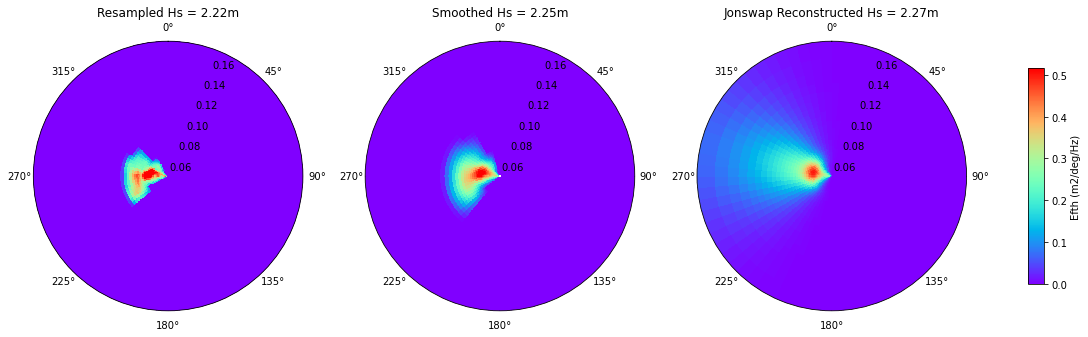

In [31]:
rmin, rmax = ds_Slope1_roll_efth.freq.min(), ds_Slope1_roll_efth.freq.max()
vmax = np.nanmax([ds_Slope1_efth.efth.max(), ds_Slope1_roll_efth.efth.max(), ds_jonswap.efth.max()])
cmap = 'rainbow'

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
gs = fig.add_gridspec(1, 3, wspace=0.2)

axa = fig.add_subplot(gs[0, 0], projection='polar')
axb = fig.add_subplot(gs[0, 1], projection='polar')
axc = fig.add_subplot(gs[0, 2], projection='polar')

ima = plot_spectra.plot_spectrum(axa, ds_Slope1_efth.dir, ds_Slope1_efth.freq, ds_Slope1_efth.efth, cmap, rmin, rmax, vmax)
imb = plot_spectra.plot_spectrum(axb, ds_Slope1_roll_efth.dir, ds_Slope1_roll_efth.freq, ds_Slope1_roll_efth.efth, cmap, rmin, rmax, vmax)
imc = plot_spectra.plot_spectrum(axc, ds_jonswap.dir.values, ds_jonswap.freq.values, ds_jonswap.efth.values, cmap, rmin, rmax, vmax)

axa.set_title('Resampled Hs = {0:.2f}m'.format(ds_Slope1_efth.spec.hs().values))
axb.set_title('Smoothed Hs = {0:.2f}m'.format(ds_Slope1_roll_efth.spec.hs().values))
axc.set_title('Jonswap Reconstructed Hs = {0:.2f}m'.format(ds_jonswap.spec.hs().values))

cbar = plt.colorbar(ima, shrink=0.3, pad=0.1)
cbar.set_label('Efth (m2/deg/Hz)')
plt.show()

In [32]:
ds_jonswap_k = spectra.density2slope(ds_jonswap)

___

## Mean parameters

In [34]:
distance, bearing, bearing_p1 = spectra.geoBearing(lon_coor, lat_coor)
ds_jonswap_k = ds_jonswap_k.assign(distance=[distance])
H, T, Cg, Ttime = spectra.propagate(ds_jonswap_k)
    
#print('Hs: {0:.2f}m\nT: {1:.2f}s\nTravel Time: {2}'.format(H, T, Ttime))

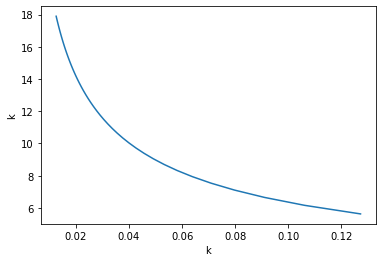

In [36]:
T.plot()

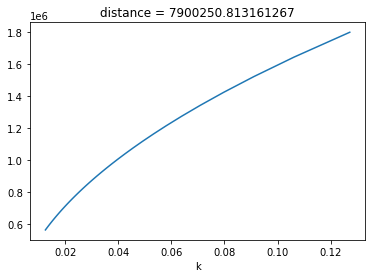

In [37]:
Ttime.plot()